**Assigment 1: Movie Review Classifiers**
---
*Author: Long Tran, Khang Pham*

# **1. Data Description and Analysis**

*Motivation*

The dataset was chosen due to its compatibility with NLP techniques using supervised learning, since the dataset came with the review itself in text format, and its label. By using different text classification algorithms, the motivation of using this dataset is to achieve the most accurate prediction of whether or not the movie review is positive or negative.



*Objective and approach*

The objective of the movie review classifiers is to train the model to predict whether the movie review is positive or negative based on provided training data (the review in the text format) combined with its corresponding label (pos/neg). The accuracy of the model using different approaches will be reported based on the train/test split validation.

The classifier will be built using two different approaches, one of which will be using the Naives Bayes algorithm - a probabilistic algorithm that take advantage of probability theory and Bayes' Theorem to predict the tag of a text, the other one would be the Logistic Regression - which uses sigmoid function to become more roburst to outliers. Since those two algorithms are famously known for its effectiveness in text classfications model they would make a great fit for the movie reviews classifier model.

- Importing and installing the necessarily packages for text processing and modelling.

In [1]:
import pandas as pd
import numpy as np
import nltk
import plotly


from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.metrics import classification_report

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from textblob import TextBlob

pip install "notebook>=5.3" "ipywidgets>=7.5"
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'plotly'

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

# **2. Data Process and Model Building**

**Data Wrangling:**

- Import the moview_review dataset from Kaggle to Googla collab notebook




In [2]:
data=pd.read_csv('movie_review.csv')
#data_logistic=pd.read_csv('movie_review.csv')

#Choosing the text(x) and tag(y) for the model
data=data.loc[:,['text','tag']]
#data_logistic=data_logistic.loc[:,['text','tag']]
print(data.head())

                                                text  tag
0  films adapted from comic books have had plenty...  pos
1  for starters , it was created by alan moore ( ...  pos
2  to say moore and campbell thoroughly researche...  pos
3  the book ( or " graphic novel , " if you will ...  pos
4  in other words , don't dismiss this film becau...  pos


**Data Visualization**

In [ ]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

data['text_clean'] = preprocess(data['text'])
data['polarity'] = data['text_clean'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['text_clean'].astype(str).apply(len)
data['word_count'] = data['text_clean'].apply(lambda x: len(str(x).split()))

In [ ]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = data.loc[data.polarity == 1, ['text_clean']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

casting debbie reynolds as beatrice is perfect .
i know this guy can act : he was awesome in " raising arizona " as goodman's partner in crime .
perhaps the sinking is best summarized by one of the guggenheim's on-board the ship .
perfect for viewers who can appreciate perverse comedy , this story never pulls its punches .
but in combination with the horror aspect , the whodunit is a perfect counterpoint .


In [ ]:
print('5 random reviews with the highest negative sentiment polarity: \n')
cl = data.loc[data.polarity == -1, ['text_clean']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest negative sentiment polarity: 

his films all seem to have one style , bleak .
the story involves gibson being double-crossed by his partner ( who is a real bad guy , which made me wish that we could root for him ) over $70 , 000 .
the lines the actresses come out with are completely horrible .
color of night is the worst movie of the year .
if de bont and screenwriter david self had let our minds fill in the blanks as to what was happening instead of showing us everything , it would have served to make the film terrifying .


In [ ]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = data.loc[data.polarity == 0, ['text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

mr . cameron brings the ship to life in an almost literal sense .
the only reason for watching is the actors .
the radio explains that an overflying airplane started coming apart .
snide underling at kim's office gets her come-uppance .
they are somehow lost in time , as it loops uncontrollably back and forth .


**The distribution of review sentiment polarity score**

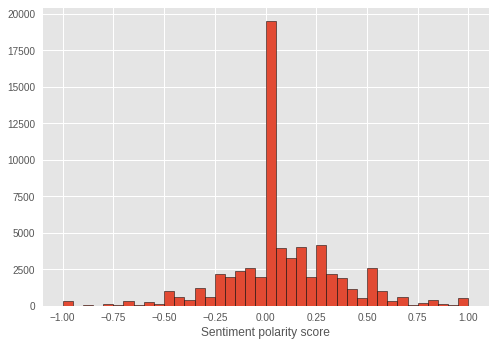

In [ ]:
plt.style.use('ggplot')
plt.hist(data['polarity'],bins=40,edgecolor='black')
plt.xlabel('Sentiment polarity score')
plt.show()

Vast majority of the sentiment polarity scores are greater than zero, means most of them are pretty positive. However, with this sentiment polarity score, most of the movie reviews are betweem -0.25 to 0.25. The maginute of the review is not too different for the categorize the review is positive or negative. The problem can lead to the quality of the model maybe not too good.

**The distribution review text lengths**

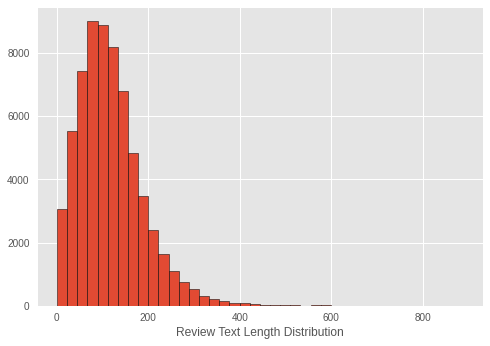

In [ ]:
plt.hist(data['review_len'],bins=40,edgecolor='black')
plt.xlabel('Review Text Length Distribution')
plt.show()

The majority of the text length is between 0-200 words for a comment.

**The distribution of review word count**

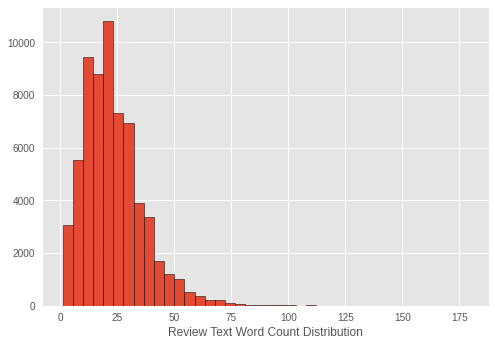

In [ ]:
plt.hist(data['word_count'],bins=40,edgecolor='black')
plt.xlabel('Review Text Word Count Distribution')
plt.show()

The majority of the word counts are from 0 to 50 words.

**Text Processing/Text Normalization**

Natural language, as a human resource, tends to follow the inherent nature of its creator randomness.

Computers are not so good at dealing with randomness (although this is being minimized with the use of Machine Learning Algorithms).

When we normalize a natural language resource, we attempt to reduce the randomness in it, bringing it closer to a predefined “standard”. This helps into reducing the amount of different information that the computer has to deal, and therefore improves efficiency.

In this review task, there are several fundamental techniques that we use to normalize the movie reviews for implementing some text classifier algorithms.



1. Capital letter removal (often, working with lowercase words deliver better results. In some cases, however, capital letters are very important to extract information, like names and locations).
2. Removal of duplicate whitespaces and punctuation
3. Removal or substitution of special characters/emojis (e.g.: remove hashtags).
4. Tokenzie the reviews
5. Lemmatization the words


In [ ]:
#Text cleaning
#Normalization

import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    #remove punctuation
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df
    
data=clean_text(data,'text','text_clean')
data.head() 

,text,tag,text_clean,polarity,review_len,word_count
0,films adapted from comic books have had plenty...,pos,films adapted from comic books have had plenty...,0.175000,265,52
1,"for starters , it was created by alan moore ( ...",pos,for starters it was created by alan moore an...,0.112121,172,36
2,to say moore and campbell thoroughly researche...,pos,to say moore and campbell thoroughly researche...,-0.130208,150,27
3,"the book ( or "" graphic novel , "" if you will ...",pos,the book or graphic novel if you will is ...,0.150000,138,30
4,"in other words , don't dismiss this film becau...",pos,in other words dont dismiss this film because...,-0.125000,64,13


In [ ]:
#tokenizing the word from normalized text
data['text_tokens'] = data['text_clean'].apply(lambda x: word_tokenize(x))
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

In [ ]:
#Lemmatization
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

data['text_tokens_lemma'] = data['text_tokens'].apply(lambda x: word_lemmatizer(x))

In [ ]:
#Convert the 'text_token_lemma' to string for 
data['text_tokens_lemma_string']= [','.join(map(str, l)) for l in data['text_tokens_lemma']]

In [ ]:
#Split the the x and y variable as the seperate columns for training the model
x=data.text_tokens_lemma_string
y=data.tag

In [ ]:
# In this section, we use the train/split test method to train and validate the model
# by default, this splits 75% training and 25% test
# random_state=1 for reproducibility 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x,y,random_state=1)

#label encode target variable
encoder=preprocessing.LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.fit_transform(y_test)

**Count Vectorization**

This process basically breaks down sentences or paragraph in a text document into words (this process is also known as tokenization) and performs basic preprocessing to the text such as converting all words to lowercase, removing punctuation mark,...

Count Vectorization then stores all of the word necessary after the tokenization process into a vector. Each word occurence in the text document will be counted and stored in correspondent with the word in an encoded vector in the end. 



In [ ]:
# instantiate the 
vect= CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
vect.fit(data['text_tokens_lemma_string'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
                vocabulary=None)

In [ ]:
# Learn the training data vocabulary, then use it to create the document-term matrix
# Then we fit the model
# Then we transfrom the model in to the document-term matrix
x_train_dtm=vect.transform(x_train)

In [ ]:
# Explore the document-term matrix
x_train_dtm

<48540x41614 sparse matrix of type '<class 'numpy.int64'>'
	with 869170 stored elements in Compressed Sparse Row format>

In [ ]:
#transform testing data (using fitted vocabulary) into a document-term matrix
x_test_dtm=vect.transform(x_test)

# 3.Mode Selection and Model Evaluation

*Model Building*

> ***Naives Bayes Classifiers***



In [ ]:
#fit the naives bayes classifiers to the dataset
NB_classfier= naive_bayes.MultinomialNB()
NB_classfier.fit(x_train_dtm,y_train)
#predict the labels on validation dataset
predictions_NB=NB_classfier.predict(x_test_dtm)

#print the accuracy for NB classifiers
print(metrics.accuracy_score(predictions_NB, y_test))

0.7053152039555006


The accuracy score of the naives bayes classifiers is 0.7053152039555006. It's quite an acceptible model for the first step.



> ***Logistic Regression with Regularization***


In this model,we use paramter C as our regularization parameter. Parameter C = 1/λ.

Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple.

Parameter C will work the other way around. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we low the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.

We will try to tuning the parameter C then find out which C will fit the data set better.




In [ ]:
c_param_range=[0.001,0.01,0.1,1,10]

for i in c_param_range:
  #fit the logistic classifiers to the dataset
  Logistic_classfier_reg= linear_model.LogisticRegression(max_iter=1000,penalty='l2',C=i)
  Logistic_classfier_reg.fit(x_train_dtm,y_train)
  #predict the labels on validation dataset
  predictions_LogReg=Logistic_classfier_reg.predict(x_test_dtm)

  #print the accuracy for NB classifiers
  print("The accuracy for logistic regression model with regularization C=",i,"is", metrics.accuracy_score(predictions_LogReg, y_test))


The accuracy for logistic regression model with regularization C= 0.001 is 0.5974660074165636
The accuracy for logistic regression model with regularization C= 0.01 is 0.6460444993819531
The accuracy for logistic regression model with regularization C= 0.1 is 0.6861557478368356
The accuracy for logistic regression model with regularization C= 1 is 0.6943139678615575
The accuracy for logistic regression model with regularization C= 10 is 0.6790482076637825


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



> The result shows that the model with C=1 brings out the better result which is 0.6943139678615575. Then we will choose the logistic model with Regularization parameter C=1 for our model.

In [ ]:
  #fit the logistic classifiers to the dataset
  Logistic_classfier_reg= linear_model.LogisticRegression(max_iter=1000,penalty='l2',C=1)
  Logistic_classfier_reg.fit(x_train_dtm,y_train)
  #predict the labels on validation dataset
  predictions_LogReg=Logistic_classfier_reg.predict(x_test_dtm)

*Model Evalulation*


> **3.1. Classification report**



*Naive Bayes Classifier*

In [ ]:
#print classification report for NB classifiers
print(classification_report(y_test,predictions_NB))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      7862
           1       0.72      0.70      0.71      8318

    accuracy                           0.71     16180
   macro avg       0.71      0.71      0.71     16180
weighted avg       0.71      0.71      0.71     16180



*Logistic Regression*

In [ ]:
#print classification report for NB classifiers
print(classification_report(y_test,predictions_LogReg))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      7862
           1       0.71      0.69      0.70      8318

    accuracy                           0.69     16180
   macro avg       0.69      0.69      0.69     16180
weighted avg       0.69      0.69      0.69     16180



Two models show similar accuracy scores for the movie review data set. 
In this case, this not really a big problem. The goal for the classification report is to check does it have any problem with the overfitting or underfitting under imbalanced dataset.

The difference is not siginificant. The classification report for the two models show the result for those two model is around 70%.m This dataset is balanced. 



> **3.2. Learning Curves**



In [ ]:
from sklearn.model_selection import learning_curve
# minimum sample size in our training set is 1 and maximum is 38832
train_sizes = [1, 500, 1000, 5000, 10000, 20000,30000, 38832]
# learning_curve function will return train_sizes, train_scores, validation_soces 
# which will later be used to plot the curve for each set
train_sizes, train_scores, validation_scores = learning_curve(
estimator = naive_bayes.MultinomialNB(),
X = x_train_dtm,
y = y_train, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

# Training scores and validation scores shape
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

# Getting the mean of the error score for each training set size (1, 500, 1000,...,38882)
# since we have 5 split (cv = 5) each score (one row) will be an average of 5 different fold
# flip the sign of the scores so we can plot easily
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

Training scores:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.272      -0.054      -0.054      -0.054      -0.054     ]
 [-0.193      -0.068      -0.068      -0.068      -0.068     ]
 [-0.0998     -0.1104     -0.1104     -0.1104     -0.1104    ]
 [-0.1269     -0.126      -0.1276     -0.1276     -0.1276    ]
 [-0.15665    -0.15565    -0.1563     -0.156      -0.156     ]
 [-0.1748     -0.17133333 -0.1719     -0.17196667 -0.17123333]
 [-0.18361145 -0.18252987 -0.18198908 -0.18191183 -0.18291615]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.49278945 -0.49278945 -0.49278945 -0.49278945 -0.49289246]
 [-0.49134734 -0.4631232  -0.46260816 -0.46260816 -0.46363824]
 [-0.47991347 -0.44880511 -0.44767202 -0.45241038 -0.45210136]
 [-0.36516275 -0.38174701 -0.37474248 -0.38298311 -0.37752369]
 [-0.34548826 -0.35300783 -0.34651834 -0.34785744 -0.35300783]
 [-0.31644005 -0.32426864 -0.31777915 -0.32406263 -0.32560775]
 [-

(0.0, 1.0)

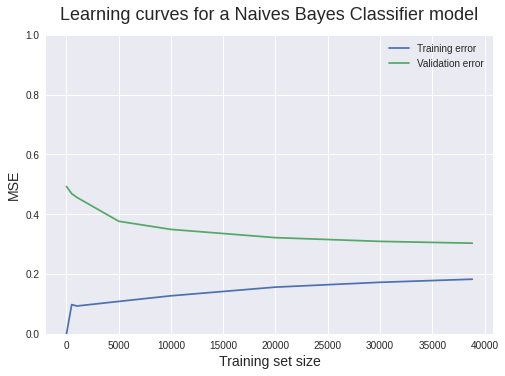

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Naives Bayes Classifier model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

First, the learning curve graph above indicates that MSE (error) is not extremely high. Second the 2 curve has not converged yet so there is still a gap in between them. This means that the learning curve is not ideal and the algorithm is suffering from high variance. Getting more training data is likely to help in this situation since the validation error could be reduced.



> Logistic *Regression*



In [ ]:
from sklearn.model_selection import learning_curve
# minimum sample size in our training set is 1 and maximum is 38832
train_sizes = [10, 500, 1000, 5000, 10000, 20000,30000, 38832]
# learning_curve function will return train_sizes, train_scores, validation_soces 
# which will later be used to plot the curve for each set
train_sizes_log, train_scores_log, validation_scores_log = learning_curve(
estimator = linear_model.LogisticRegression(max_iter=500,penalty='l2',C=1),
X = x_train_dtm,
y = y_train, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error',shuffle=True)

# Training scores and validation scores shape
print('Training scores:\n\n', train_scores_log)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores_log)

# Getting the mean of the error score for each training set size (1, 500, 1000,...,38882)
# since we have 5 split (cv = 5) each score (one row) will be an average of 5 different fold
# flip the sign of the scores so we can plot easily
train_scores_log_mean = -train_scores_log.mean(axis = 1)
validation_scores_log_mean = -validation_scores_log.mean(axis = 1)

Training scores:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.002      -0.012      -0.004      -0.012      -0.004     ]
 [-0.007      -0.015      -0.007      -0.01       -0.011     ]
 [-0.0404     -0.0478     -0.044      -0.0454     -0.0456    ]
 [-0.0704     -0.0714     -0.0686     -0.0697     -0.0735    ]
 [-0.10455    -0.10115    -0.1012     -0.105      -0.10115   ]
 [-0.1241     -0.12206667 -0.12243333 -0.11936667 -0.12136667]
 [-0.13354965 -0.13280284 -0.13334363 -0.13231356 -0.13174701]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.52492789 -0.4934075  -0.50648949 -0.49268644 -0.50236918]
 [-0.45313144 -0.45014421 -0.43665019 -0.44746601 -0.46209312]
 [-0.43726823 -0.43119077 -0.43562011 -0.43737124 -0.44056448]
 [-0.38370416 -0.39266584 -0.38215904 -0.39235682 -0.39245983]
 [-0.35280181 -0.36073342 -0.36454471 -0.368356   -0.36948908]
 [-0.33693861 -0.34023486 -0.33807169 -0.34054388 -0.33910177]
 [-

(0.0, 1.0)

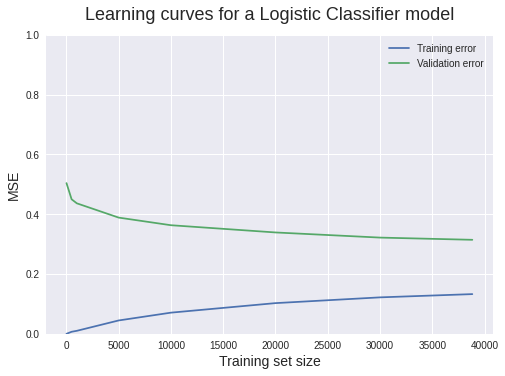

In [ ]:
plt.style.use('seaborn')
plt.plot(train_sizes_log, train_scores_log_mean, label = 'Training error')
plt.plot(train_sizes_log, validation_scores_log_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Logistic Classifier model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

# **4.Disscussion and Further Questions**

In reality, the Naives Bayes Classifiers and Logistic Regression are proved that they are really effective in the text classfication with binary outcome (positive and negative). With the accuracy result from the model above, we can see that those two algorithms perform really well with this moview review dataset. However, as we mentioned above, the data set with the majority of the reviews are neutral (-0.25 to 0.25 sentiment polarity scores). It maybe one of the biggest problems into the performence of the model.

In the future, to enhance the performence for this movie review classifers, we can spend more efforts into processing the text. We need some more advanced tools to deal with this problem before applying any classifiers for better results.

As we constructing the learning curve for training error and validation error. We can see that the algorithm is suffering from high variance since there is a gap between the two curves. With that being said, if we were to try to improve the model for future use, collecting more data would likely to help reducing the validation error and close the gap between training error and validation error curve.

Moreover, the training time is longer for the logistic classifer than we expected. One of the reason is the hyper parameter tuning for regularized C. And another reason is to converge the cost function, it requires more iterations than default. One of the solution we might come in the future is stochastic or minibatch gradient descent for optimal training time.